In [70]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
# from qolmat.diffusion_model  import ImputerDiffusion
# from qolmat.model  import TabDDPM, TsDDPM
from diffusion import DDPM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from load_data import prepare_data, aggregate_market_data
from models import CustomTransformerTimeSeries
from dataloader import TimeSeriesDataset

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

## Load Data

In [73]:
from_year = "1999"
end_year = "2019"
start_year_test = "2020"

In [74]:
data = aggregate_market_data()
df_reindexed, df_orig, df = prepare_data(data, from_year = from_year, start_year_test = None)

100%|██████████| 141/141 [00:00<00:00, 198.85it/s]


### Preprocess Data

In [75]:
train_df = df_reindexed#.loc[:'2019']
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)

## Hyperparameters

In [7]:
# hyperparameters

# diffusion hyperparameters
timesteps = 50
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
input_size = 30
hidden_dim = 32
n_feat = df_reindexed.shape[1] 
save_dir = './weights/'

# training hyperparameters
batch_size = 64
n_epoch = 50
lrate=1e-3

## TSGM

### Models

In [8]:
#model = CustomTransformerTimeSeries(input_size=input_size, n_feat=n_feat, hidden_size=32, num_layers=2, num_heads=2, dropout_prob=0.1)

In [9]:
from models import AutoEncoder, ResidualBlockTS
model = AutoEncoder(num_noise_steps=timesteps,
                    dim_input=n_feat,
                    dim_output=n_feat,
                    residual_block=ResidualBlockTS(hidden_dim, input_size, hidden_dim),
                    dim_embedding=hidden_dim,
)

In [10]:
# model_qolmat = TsDDPM(num_noise_steps=50,nheads_feature=8,nheads_time=8)

### Training

In [11]:
train_dataset = TimeSeriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
optim = torch.optim.Adam(model.parameters(), lr=lrate)

In [51]:
from models import AutoEncoder, ResidualBlockTS, RNNEncDec
score_model = AutoEncoder(num_noise_steps = timesteps,
                    dim_input = 2*n_feat,
                    dim_output = n_feat,
                    residual_block = ResidualBlockTS(hidden_dim, input_size-1, hidden_dim),
                    dim_embedding = hidden_dim,
).to(device)

RNN_model = RNNEncDec(n_feat,
                      4,
                      device)

from diffusion import TSGM
tsgm = TSGM(score_model=score_model,
            RNN_model=RNN_model,
            num_noise_steps=timesteps,
            beta_0=beta1,
            beta_1=beta2,
            n_epoch_train=25,
            n_epoch_pretrain=20,
            lrate=lrate,
            device=device)


c:\Users\khale\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd



In [53]:
# train full model
losses = tsgm.train(train_loader, use_alt=True)

Epoch 1/20, Loss: 0.9078326195478439
Epoch 2/20, Loss: 0.8891020965576172
Epoch 3/20, Loss: 0.8783262741565704
Epoch 4/20, Loss: 0.8671764129400253
Epoch 5/20, Loss: 0.860159278512001
Epoch 6/20, Loss: 0.8418406486511231
Epoch 7/20, Loss: 0.8293479290604592
Epoch 8/20, Loss: 0.8167098242044449
Epoch 9/20, Loss: 0.8043760514259338
Epoch 10/20, Loss: 0.791581717133522
Epoch 11/20, Loss: 0.7782569602131844
Epoch 12/20, Loss: 0.7695388616621495
Epoch 13/20, Loss: 0.7601820015907288
Epoch 14/20, Loss: 0.7538464251160621
Epoch 15/20, Loss: 0.7372692799568177
Epoch 16/20, Loss: 0.7264217239618301
Epoch 17/20, Loss: 0.7255357363820076
Epoch 18/20, Loss: 0.7148065808415413
Epoch 19/20, Loss: 0.7020610743761062
Epoch 20/20, Loss: 0.6876055811345577


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 1/25, Loss: 52.048832367062566


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 2/25, Loss: 36.722014459371564


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 3/25, Loss: 33.870689668655395


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 4/25, Loss: 31.72429790377617


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 5/25, Loss: 31.3318937933445


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 6/25, Loss: 30.74238086372614


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 7/25, Loss: 29.629800728559495


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 8/25, Loss: 29.237801510691643


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 9/25, Loss: 28.82072621136904


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 10/25, Loss: 28.557127836346627


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 11/25, Loss: 28.45985691845417


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 12/25, Loss: 28.228956220746042


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 13/25, Loss: 28.2025983697176


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 14/25, Loss: 28.243623870015146


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 15/25, Loss: 28.081025907099246


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 16/25, Loss: 28.05065703034401


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 17/25, Loss: 27.94350020468235


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 18/25, Loss: 27.943273400068282


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 19/25, Loss: 27.990628002882005


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 20/25, Loss: 27.82227324217558


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch 21/25, Loss: 27.899823300242424


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 22/25, Loss: 27.76221242427826


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch 23/25, Loss: 27.76223024100065


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 24/25, Loss: 27.732379878461362


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]

Epoch 25/25, Loss: 27.703041520118713


Epoch 1/20, Loss: 1.7826259315013886
Epoch 2/20, Loss: 1.4559328716993332
Epoch 3/20, Loss: 1.2308226871490477
Epoch 4/20, Loss: 1.1001699927449227
Epoch 5/20, Loss: 1.028002536892891
Epoch 6/20, Loss: 0.9789609336853027
Epoch 7/20, Loss: 0.9669415456056595
Epoch 8/20, Loss: 0.9619678819179535
Epoch 9/20, Loss: 0.9580978760123253
Epoch 10/20, Loss: 0.9553691732883454
Epoch 11/20, Loss: 0.9517618790268898
Epoch 12/20, Loss: 0.9479356569051742
Epoch 13/20, Loss: 0.9450626027584076
Epoch 14/20, Loss: 0.9424784940481186
Epoch 15/20, Loss: 0.9394661992788315
Epoch 16/20, Loss: 0.9368289628624916
Epoch 17/20, Loss: 0.9326113951206207
Epoch 18/20, Loss: 0.9265895637869835
Epoch 19/20, Loss: 0.9213551977276802
Epoch 20/20, Loss: 0.9158327999711037


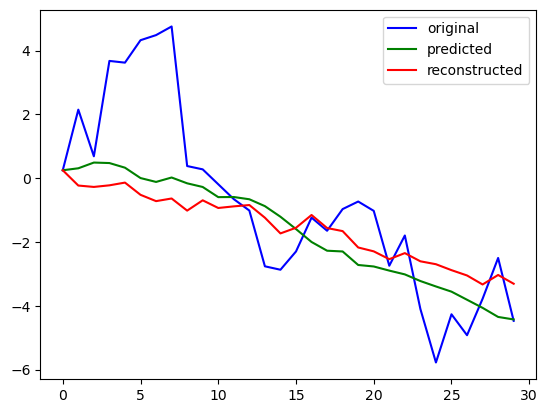

In [52]:
# pretrain the RNN model and test it
test_pretrain = True
if test_pretrain:
    # RNN_losses = tsgm.pretrain_RNN(train_loader)
    i = 0
    seq_len = 30
    a = X_train[i:i+seq_len, :]

    memory = tsgm.RNN.encoder(a)
    b = tsgm.RNN.predict(a[:1], memory.unsqueeze(0)).squeeze(0)
    
    c = tsgm.RNN(a.unsqueeze(0)).squeeze(0)

    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()
    c = c.detach().cpu().numpy()

    a_cum = np.cumsum(a, axis=0)
    b_cum = np.cumsum(b, axis=0)
    c_cum = np.cumsum(c, axis=0)

    plt.plot(a_cum[:,0], label='original', color='blue')
    plt.plot(b_cum[:,0], label='predicted', color='green')
    plt.plot(c_cum[:,0], label='reconstructed', color='red')
    plt.legend()
    plt.show()

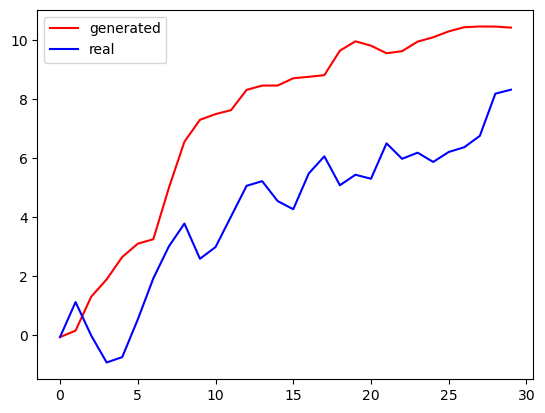

In [65]:
# take a random start
sample_size = 1
seq_len = 30
start_indices = np.random.randint(0, X_train.shape[0], sample_size)
start = X_train[start_indices, :]
gen_samples = tsgm.sample(start, sample_size, seq_len, n_feat)

i = 0
a = gen_samples[i, :, 0].cpu().detach().numpy()
b = X_train[start_indices[i]:start_indices[i]+seq_len, 0].cpu().detach().numpy()
a_cum = np.cumsum(a)
b_cum = np.cumsum(b)
plt.plot(a_cum, color = 'r', label = 'generated')
plt.plot(b_cum, color = 'b', label = 'real')
plt.legend()
plt.show()

In [66]:
# evaluation
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data

n_samples = 100
seq_len = 30

samples_orig = torch.zeros((n_samples, seq_len, n_feat))
for i in range(n_samples):
    idx = np.random.randint(0, X_train.shape[0]-seq_len)
    samples_orig[i] = X_train[idx:idx+seq_len]

start = samples_orig[:, 0, :]
gen_samples = tsgm.sample(start, n_samples, seq_len, n_feat)

samples_orig = samples_orig.cpu().detach().numpy()
gen_samples = gen_samples.cpu().detach().numpy()

eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=0.8)
eval_results

c:\Users\khale\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Training LDS model...
Epoch [1/10], Loss: 0.10389690473675728
Epoch [2/10], Loss: 0.09871208481490612
Epoch [3/10], Loss: 0.09137517213821411
Epoch [4/10], Loss: 0.08833757229149342
Epoch [5/10], Loss: 0.08184652030467987
Epoch [6/10], Loss: 0.07681465987116098
Epoch [7/10], Loss: 0.07232367154210806
Epoch [8/10], Loss: 0.0669743474572897
Epoch [9/10], Loss: 0.0610628267750144
Epoch [10/10], Loss: 0.056186397559940815
Training LPS model...
Epoch [1/20], Loss: 0.6967171281576157
Epoch [2/20], Loss: 0.512230820953846
Epoch [3/20], Loss: 0.4973236545920372
Epoch [4/20], Loss: 0.4031017832458019
Epoch [5/20], Loss: 0.4084780514240265
Epoch [6/20], Loss: 0.379710890352726
Epoch [7/20], Loss: 0.44537337124347687
Epoch [8/20], Loss: 0.34665732830762863
Epoch [9/20], Loss: 0.32516326382756233
Epoch [10/20], Loss: 0.3390390872955322
Epoch [11/20], Loss: 0.31746741384267807
Epoch [12/20], Loss: 0.32015547156333923
Epoch [13/20], Loss: 0.3231462463736534
Epoch [14/20], Loss: 0.3014095723628998
Ep

{'LDS': 0.15000000000000002,
 'LPS': 0.6570663,
 'KL Divergence Columns': 1.360998762689989,
 'KL Divergence Rows': 1.2757215824891133,
 'Wasserstein Distance Columns': 0.2210707757606633,
 'Wasserstein Distance Rows': 0.47270362126907894}

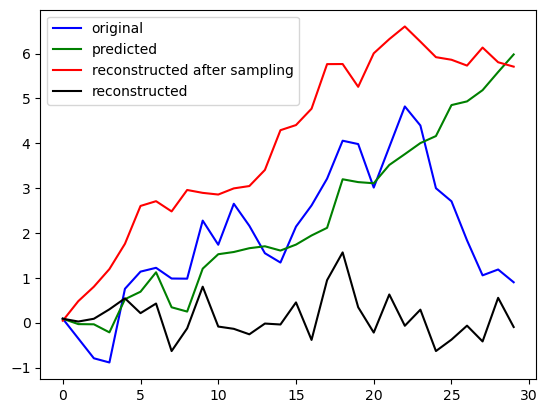

In [69]:
i = np.random.randint(0, n_samples)
feat = np.random.randint(0, n_feat)
a = samples_orig[i]
b, h =tsgm.sample(torch.from_numpy(a[0].reshape(1, 53)), 1, 30, 53, return_h=True)
c = tsgm.RNN.decoder(torch.from_numpy(a.reshape(1, 30, 53)), h)
d = tsgm.RNN(torch.from_numpy(a.reshape(1, 30, 53)))

b = b.squeeze(0).detach().cpu().numpy()
c = c.squeeze(0).detach().cpu().numpy()
d = d.squeeze(0).detach().cpu().numpy()

a_cum = np.cumsum(a, axis=0)
b_cum = np.cumsum(b, axis=0)
c_cum = np.cumsum(c, axis=0)

plt.plot(a_cum[:,feat], label='original', color='blue')
plt.plot(b_cum[:,feat], label='predicted', color='green')
plt.plot(c_cum[:,feat], label='reconstructed after sampling', color='red')
plt.plot(d[:,feat], label='reconstructed', color='black')
plt.legend()
plt.show()

In [91]:
start = X_train[0, :].unsqueeze(0)
seq_len = 100
n_samples = torch.tensor(1)
gen_samples = tsgm.sample(start, n_samples, seq_len, n_feat)

: 

#### Visualisations

In [76]:
df_orig = df_orig['Ret'].unstack().T

In [77]:
synth_data = gen_samples.reshape(-1, gen_samples.shape[2]).shape

In [78]:
synth_data = pd.DataFrame(gen_samples[0,:,:], index=df_orig[start_year_test:].index[:input_size], columns=df_orig.columns)

In [79]:
from plot_results import plot_data

In [80]:
columns = df_orig.columns.tolist()
starting_point = df_orig[:end_year].cumsum().dropna().iloc[-1]
plot_data(df_orig, synth_data, starting_point, columns[:10])

In [81]:
from evaluation_metrics import kl_divergence_columns, kl_divergence_rows, wasserstein_distance_columns, wasserstein_distance_rows, compute_frobenius_norm, compute_condition_number, compute_spectral_norm

In [82]:
true_data = df_orig[start_year_test:]

In [83]:
kl_col = kl_divergence_columns(synth_data,true_data)
kl_rows = kl_divergence_rows(synth_data,true_data)
wasserstein_col = wasserstein_distance_columns(synth_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synth_data,true_data)


In [84]:
kl_col.mean().values[0]

2.3894031376932965

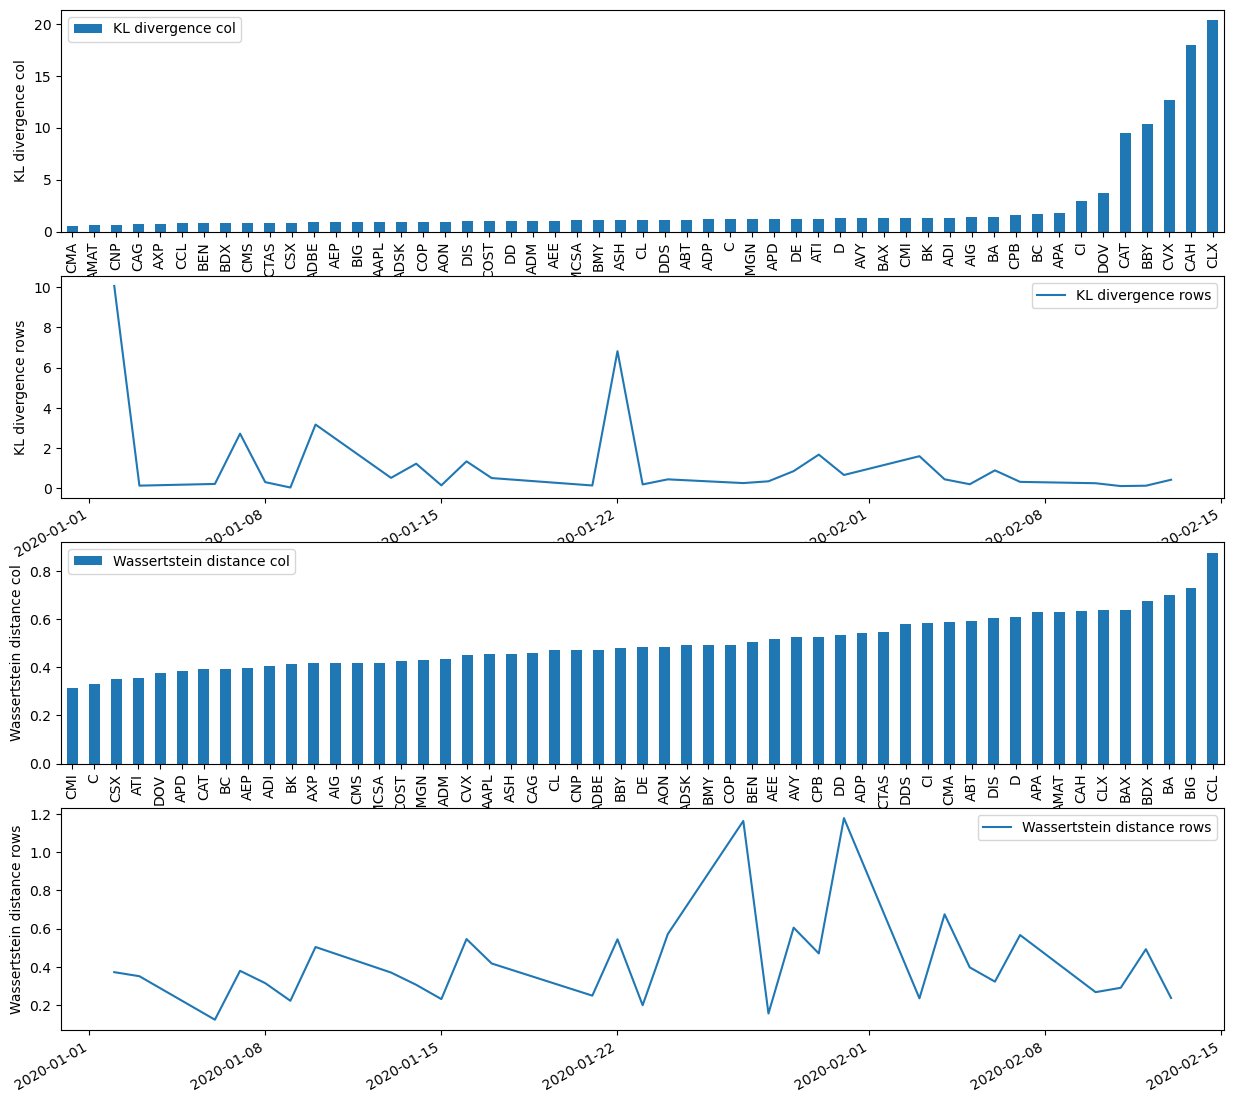

In [85]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


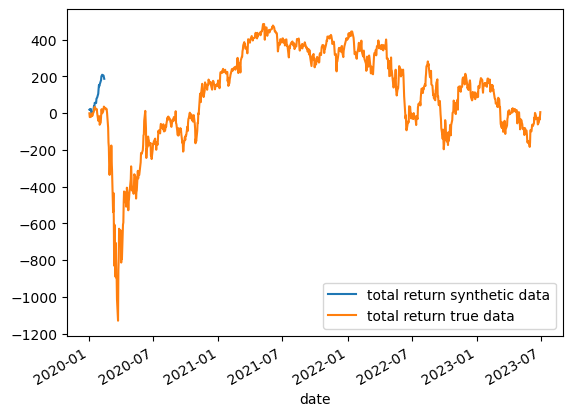

In [86]:
synth_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

In [87]:
cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synth_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")



Frobenius Norm: 28.950694161742557
Spectral Norm: 27.85822645606713
Condition Number - True Data: 383.2139665503994
Condition Number - Synthetic Data: 9.530005185228024e+18


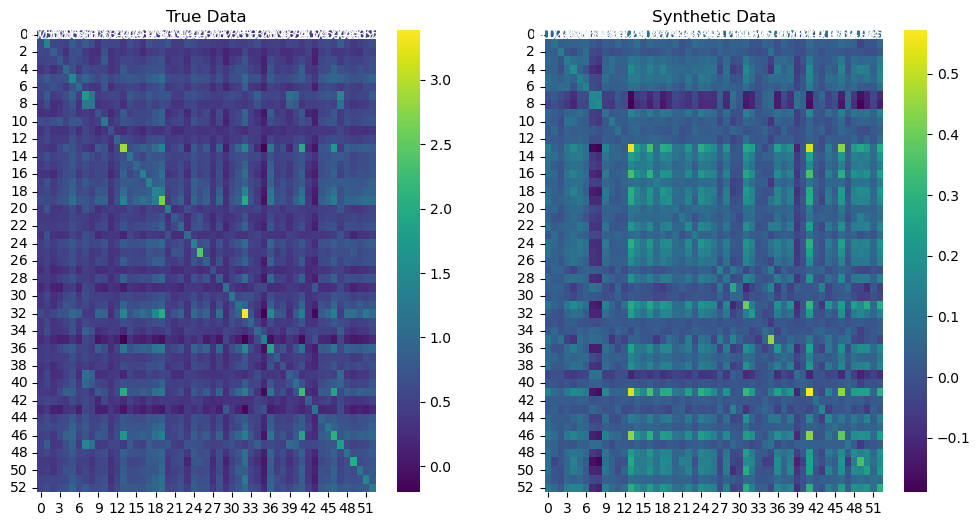

In [88]:
from plot_results import plot_covariance_matrices, plot_eigenvalues
# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


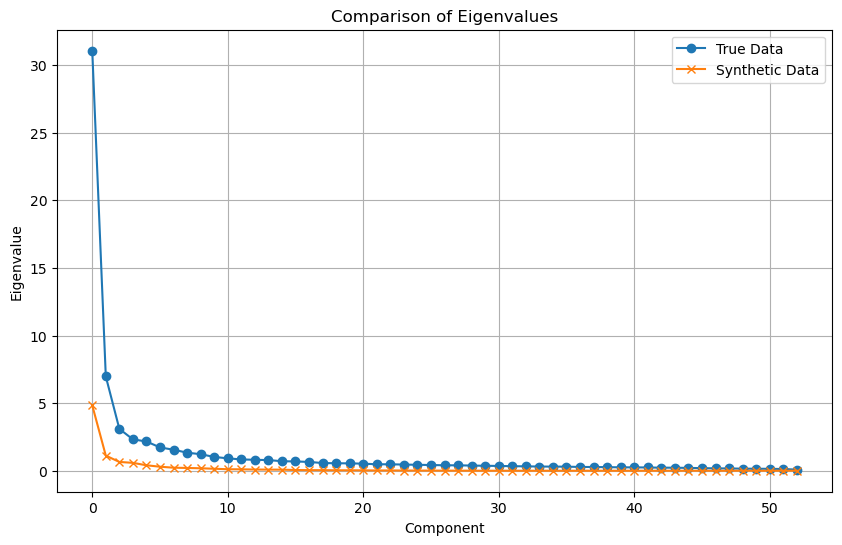

In [89]:
from evaluation_metrics import eigen_decomposition
from plot_results import plot_eigenvalues
# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)


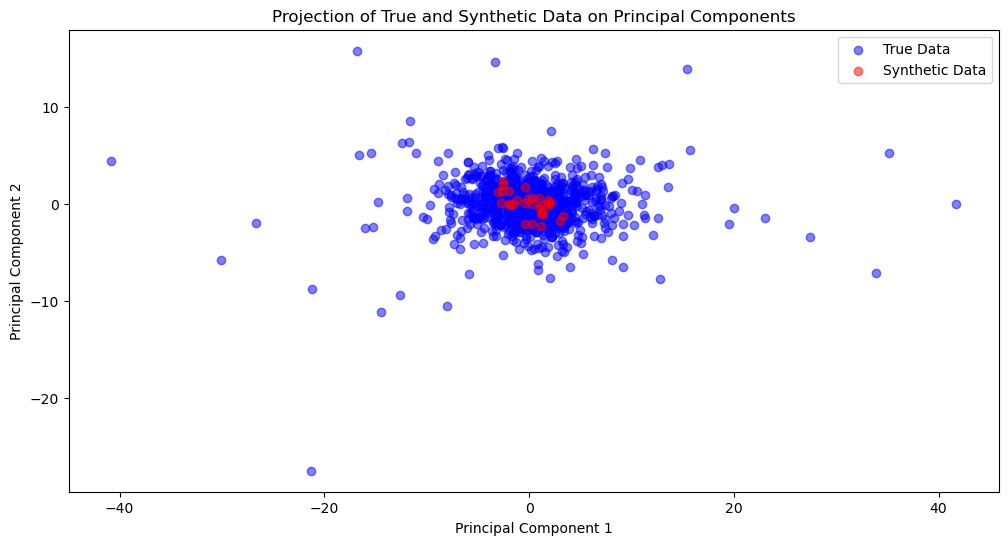

In [90]:
from evaluation_metrics import compute_principal_components, project_onto_principal_components
from plot_results import plot_projection_on_principal_components


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synth_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)


## DDPM

In [34]:
ddpm = DDPM(model = model, 
            optimizer = optim,
            device = device, 
            timesteps = timesteps, 
            beta1 = beta1, 
            beta2 = beta2, 
            n_epoch = n_epoch, 
            batch_size = batch_size, 
            lrate = lrate, 
            save_dir = save_dir)

In [ ]:
losses, maes, wasserstein_distances =ddpm.train(train_loader=train_loader)

In [ ]:
# Convert lists to DataFrame
metrics_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot metrics
metrics_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

In [ ]:
n_sample = X_train.shape[0] // input_size

In [ ]:
gen_samples, _  = ddpm.sample(n_sample = n_sample, window_size = input_size, dim_input = n_feat, save_rate=20)

In [ ]:
"""tabddpm = ImputerDiffusion(
    model_qolmat, epochs=n_epoch, batch_size=batch_size, x_valid=df_reindexed, print_valid=True,index_datetime='date',
      freq_str = '1B',columnwise=False)"""
#tabddpm.fit(df_reindexed)
#pd.DataFrame(tabddpm.model.summary).plot(subplots=True)
#plt.xlabel('epochs')

### Evaluation

In [174]:
import json
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data
#path_results = os.getcwd() + "\\results\\DDPM\\"
path_results = os.getcwd() + "\\100\\"
parameters = [d for d in os.listdir(path_results) if os.path.isdir(os.path.join(path_results, d))]
print(parameters)
for param in parameters:
    print(param)
    path_parameters = path_results + param
    var = [d for d in os.listdir(path_parameters) if os.path.isdir(os.path.join(path_parameters, d))]
    print(var)
    train_ratio = 0.8
    results = {}
    for v in var:
        print(v)
        config_results = json.load(open(path_parameters + "\\" + v + '\\config.json', 'r'))
        #create  samples from df_orig time series
        seq_len = config_results["SEQ_LEN"]
        n_samples = X_train.shape[0] // seq_len
        samples_orig = np.zeros((n_samples, seq_len, n_feat))
        for i in range(n_samples):
            idx = np.random.randint(0, df_orig.shape[0]-seq_len)
            samples_orig[i] = df_orig.iloc[idx:idx+seq_len].values

        gen_samples = np.load(path_parameters + "\\" + v + '\\samples.npy')[:n_samples]
        eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
        eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
        eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=train_ratio)
        results[v] = eval_results    
    results_df = pd.DataFrame(results).T
    results_df.index = results_df.index.astype(float)
    results_df = results_df.sort_index()
    results_df.index.name = param
    results_df.plot(subplots=True, figsize=(10, 8), linewidth=2, marker='o')
    plt.xticks(results_df.index)
    plt.savefig('.\\plots\\' + param + '_epoch_300_timesteps_100'+'.png')

[]


#### Visualisations

In [95]:
df_orig = df_orig['Ret'].unstack().T

In [96]:
synth_data = gen_samples.reshape(-1, gen_samples.shape[2]).shape

In [98]:
synth_data = pd.DataFrame(gen_samples[0,:,:].detach().numpy(), index=df_orig[start_year_test:].index[:input_size], columns=df_orig.columns)

In [99]:
from plot_results import plot_data

In [100]:
columns = df_orig.columns.tolist()
starting_point = df_orig[:end_year].cumsum().dropna().iloc[-1]
plot_data(df_orig, synth_data, starting_point, columns[:10])

In [101]:
from evaluation_metrics import kl_divergence_columns, kl_divergence_rows, wasserstein_distance_columns, wasserstein_distance_rows, compute_frobenius_norm, compute_condition_number, compute_spectral_norm

In [102]:
true_data = df_orig[start_year_test:]

In [103]:
kl_col = kl_divergence_columns(synth_data,true_data)
kl_rows = kl_divergence_rows(synth_data,true_data)
wasserstein_col = wasserstein_distance_columns(synth_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synth_data,true_data)


In [104]:
kl_col.mean().values[0]

5.200691360910532

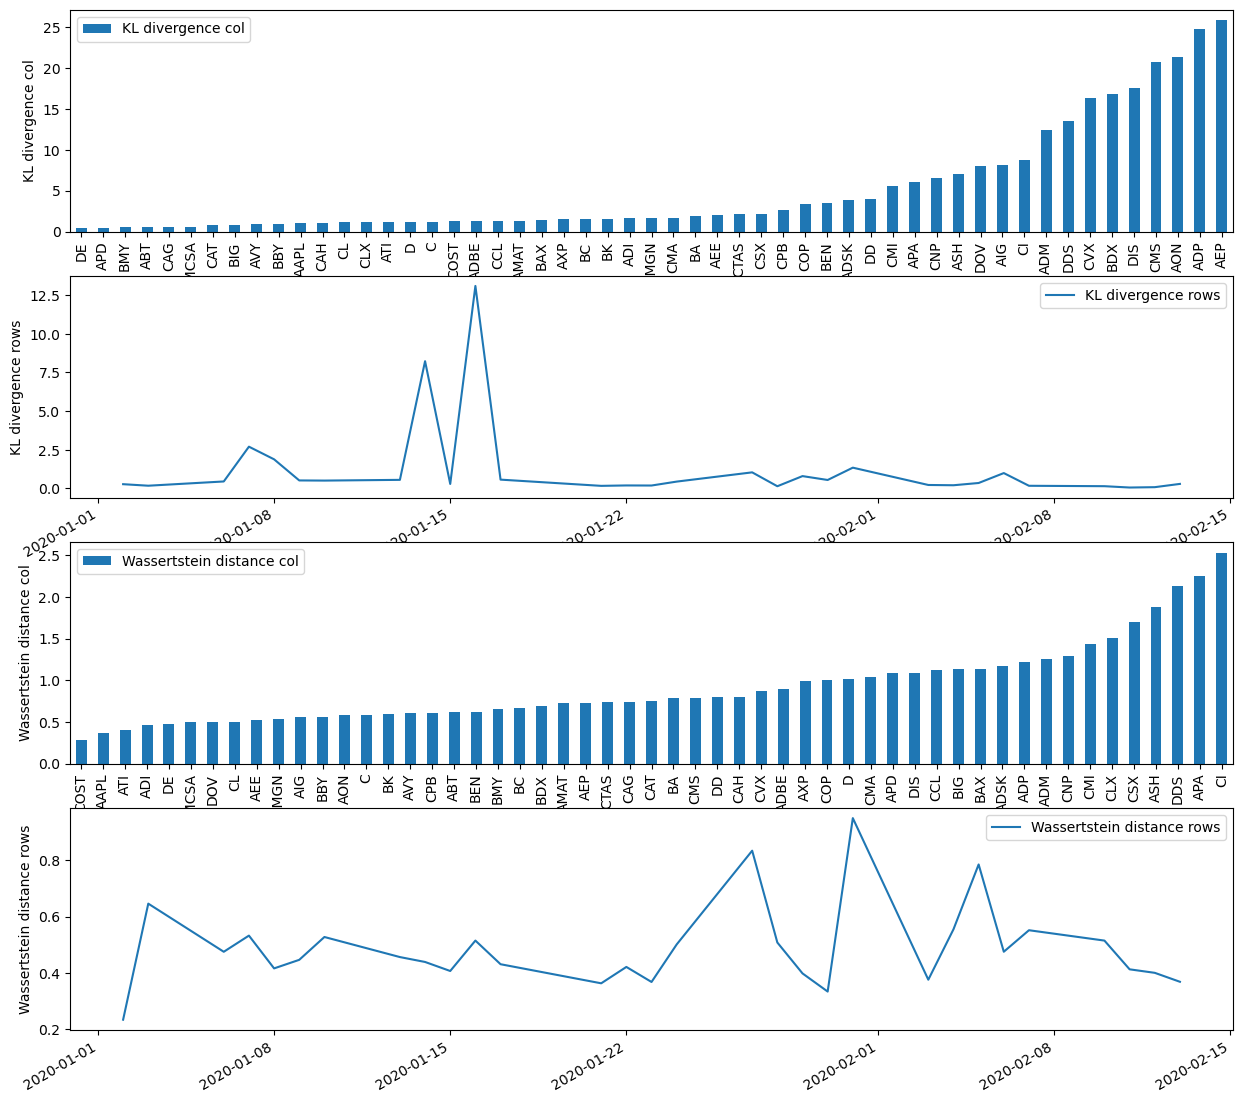

In [105]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


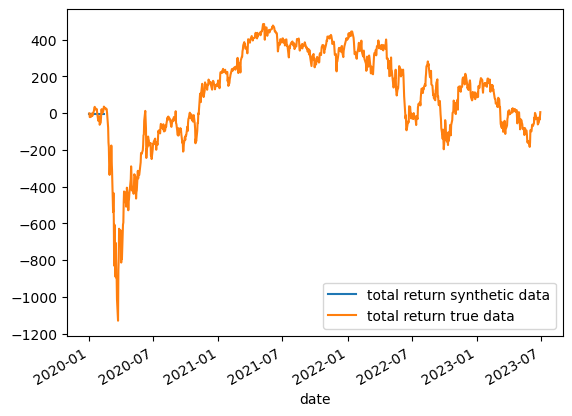

In [106]:
synth_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

In [108]:
cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synth_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")



Frobenius Norm: 32.559734089017454
Spectral Norm: 31.053636008241302
Condition Number - True Data: 383.2139665503994
Condition Number - Synthetic Data: 1.0633268944163506e+18


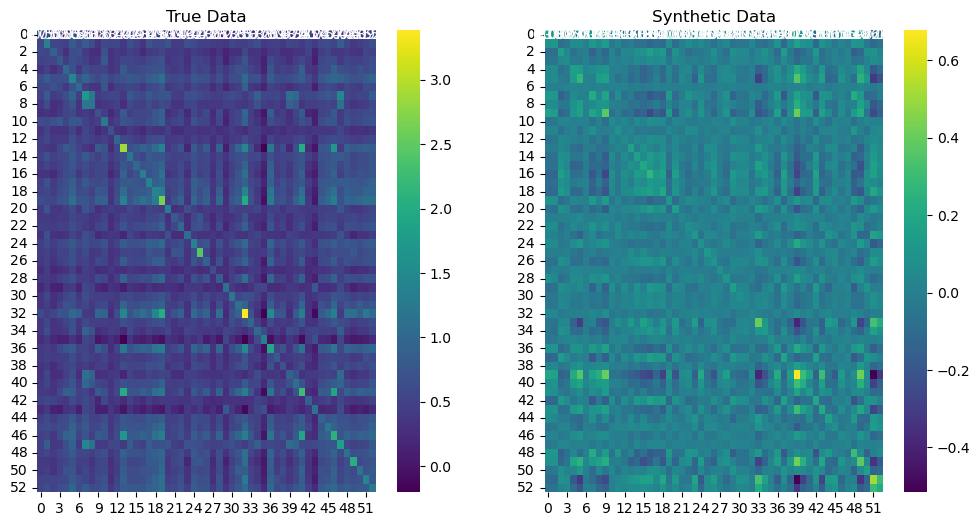

In [109]:
from plot_results import plot_covariance_matrices, plot_eigenvalues
# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


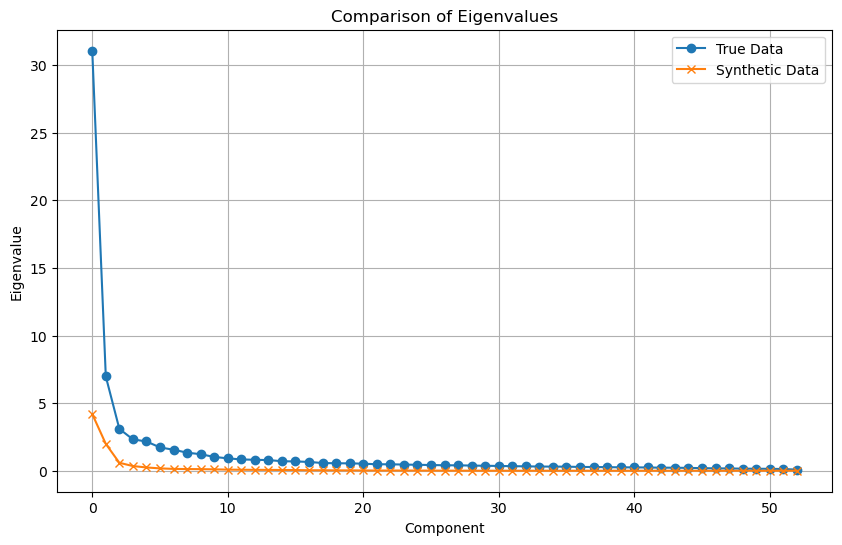

In [110]:
from evaluation_metrics import eigen_decomposition
from plot_results import plot_eigenvalues
# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)


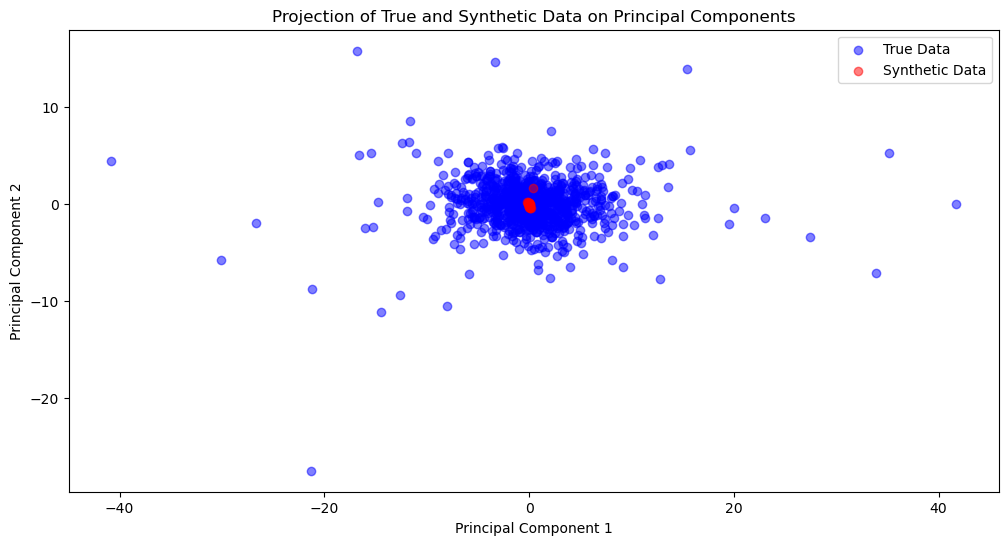

In [111]:
from evaluation_metrics import compute_principal_components, project_onto_principal_components
from plot_results import plot_projection_on_principal_components


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synth_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)
